# Fine-tune SentenceTransformer Models for ITSM Tickets (v4)
Self-contained pipeline to train a similarity model and (optionally) a relationship classifier.
## V4 changes
- Improved positive pair generation using Category and Subcategory.
- Increased early stopping patience to 3.
- Implemented SMOTE to handle class imbalance in the relationship classifier.

## 1. Setup and Imports

In [14]:

import os
import sys
import json
import math
import random
import logging
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.utils.data import DataLoader

from sentence_transformers import SentenceTransformer, InputExample, losses
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from transformers import TrainerControl

try:
    from imblearn.over_sampling import SMOTE
    IMBLEARN_AVAILABLE = True
except ImportError:
    print('imbalanced-learn is not installed. Relationship classifier will be skipped.')
    IMBLEARN_AVAILABLE = False

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

print("✅ Imports successful")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")


✅ Imports successful
PyTorch version: 2.9.0+cu126
Device: CUDA


In [15]:
import os
os.environ["WANDB_DISABLED"] = "true"
print("Wandb logging disabled.")

Wandb logging disabled.


## 2. Configuration

In [16]:

# Base configuration (override as needed)
CONFIG = {
    'base_model': 'sentence-transformers/all-mpnet-base-v2',
    'output_dir': 'models/all-mpnet-finetuned-v4',
    'source_data': 'data/dummy_data_promax.csv',
    'epochs': 8,
    'batch_size': 16,
    'learning_rate': 1e-5,
    'warmup_steps': 200,
    'eval_split': 0.15,
    'max_seq_length': 256,
    'eval_steps': 50,
}

# Derived paths (ensure plain string path)
output_dir_str = str(CONFIG['output_dir'])
output_path = output_dir_str if os.path.isabs(output_dir_str) else os.path.join(os.getcwd(), output_dir_str)
os.makedirs(output_path, exist_ok=True)
print(f"Output directory: {output_path}")

Output directory: /content/models/all-mpnet-finetuned-v4


In [17]:

# Global seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
print(f"Seeds set to {SEED}")


Seeds set to 42


## 3. Load Training Data (dummy_data_promax)

In [18]:

# Build training pairs directly from dummy_data_promax.csv
from itertools import combinations

raw_data_path = CONFIG.get('source_data') or os.path.join('data', 'dummy_data_promax.csv')
if not os.path.isabs(raw_data_path):
    raw_data_path = os.path.join(os.getcwd(), raw_data_path)

if not os.path.exists(raw_data_path):
    raise FileNotFoundError(f"Expected input data at {raw_data_path}. Ensure dummy_data_promax is available.")

required_columns = ["Number", "Short Description", "Description", "Category", "Subcategory"]
df = pd.read_csv(raw_data_path)
missing_columns = [col for col in required_columns if col not in df.columns]
if missing_columns:
    raise ValueError(f"Missing expected columns in {raw_data_path}: {missing_columns}")

# Normalize text fields to align with the new headers
for col in ["Short Description", "Description"]:
    df[col] = df[col].fillna("").astype(str).str.strip()
for col in ["Category", "Subcategory"]:
    df[col] = df[col].fillna("Unknown").astype(str).str.strip()

# Combine short description and description for the embedding text
combined_text = (df["Short Description"] + ". " + df["Description"]).str.strip()
combined_text = combined_text.str.replace(r'^\.\s*', '', regex=True)
df["text"] = combined_text

print(f"Loaded {len(df)} incidents from {raw_data_path}")
print("Columns used:", required_columns)
print(df[required_columns].head(3))

positive_pairs = []
max_pairs_per_group = 150 # Reduced slightly to account for more groups
random.seed(SEED)

# V4 change: Group by both Category and Subcategory for more specific positive pairs
for group_name, group in df.groupby(["Category", "Subcategory"]):
    idxs = list(group.index)
    if len(idxs) < 2:
        continue
    combos = list(combinations(idxs, 2))
    random.shuffle(combos)
    for idx1, idx2 in combos[:max_pairs_per_group]:
        row1 = df.loc[idx1]
        row2 = df.loc[idx2]
        positive_pairs.append({
            "ticket1_id": row1["Number"],
            "ticket2_id": row2["Number"],
            "text1": row1["text"],
            "text2": row2["text"],
            "category1": row1["Category"],
            "category2": row2["Category"],
            "subcategory1": row1["Subcategory"],
            "subcategory2": row2["Subcategory"],
        })

if not positive_pairs:
    raise ValueError("No positive pairs could be created; check category distribution in the dataset.")

all_indices = list(df.index)

def create_hard_negatives(df, target_count, seed=42):
    """
    Create hard negatives that share some keywords but different categories.
    Adds guards for sparse categories and empty texts.
    """
    random.seed(seed)
    negatives = []
    attempts = 0
    max_attempts = target_count * 20

    category_groups = {cat: group for cat, group in df.groupby("Category")}
    categories = list(category_groups.keys())

    if len(categories) < 2:
        print("Not enough distinct categories for hard negatives; falling back to random negatives.")
        while len(negatives) < target_count:
            i, j = random.sample(all_indices, 2)
            if df.at[i, "Category"] != df.at[j, "Category"]:
                row1, row2 = df.loc[i], df.loc[j]
                negatives.append({
                    "ticket1_id": row1["Number"],
                    "ticket2_id": row2["Number"],
                    "text1": row1["text"],
                    "text2": row2["text"],
                    "category1": row1["Category"],
                    "category2": row2["Category"],
                    "subcategory1": row1["Subcategory"],
                    "subcategory2": row2["Subcategory"],
                })
        return negatives

    while len(negatives) < target_count and attempts < max_attempts:
        attempts += 1

        cat1, cat2 = random.sample(categories, 2)

        idx1 = random.choice(category_groups[cat1].index)
        idx2 = random.choice(category_groups[cat2].index)

        row1 = df.loc[idx1]
        row2 = df.loc[idx2]

        words1 = set(row1['text'].lower().split())
        words2 = set(row2['text'].lower().split())
        if not words1 or not words2:
            overlap = 0.0
        else:
            overlap = len(words1 & words2) / max(len(words1), len(words2))

        if 0.1 < overlap < 0.4:
            negatives.append({
                "ticket1_id": row1["Number"],
                "ticket2_id": row2["Number"],
                "text1": row1["text"],
                "text2": row2["text"],
                "category1": row1["Category"],
                "category2": row2["Category"],
                "subcategory1": row1["Subcategory"],
                "subcategory2": row2["Subcategory"],
            })

    while len(negatives) < target_count:
        i, j = random.sample(all_indices, 2)
        if df.at[i, "Category"] != df.at[j, "Category"]:
            row1, row2 = df.loc[i], df.loc[j]
            negatives.append({
                "ticket1_id": row1["Number"],
                "ticket2_id": row2["Number"],
                "text1": row1["text"],
                "text2": row2["text"],
                "category1": row1["Category"],
                "category2": row2["Category"],
                "subcategory1": row1["Subcategory"],
                "subcategory2": row2["Subcategory"],
            })

    return negatives

negative_pairs = create_hard_negatives(df, len(positive_pairs), seed=SEED)
print(f"Created {len(negative_pairs)} hard negative pairs")

print(f"Loaded pairs from {os.path.basename(raw_data_path)}: {len(positive_pairs)} positive, {len(negative_pairs)} negative")


Loaded 10000 incidents from /content/data/dummy_data_promax.csv
Columns used: ['Number', 'Short Description', 'Description', 'Category', 'Subcategory']
       Number                                  Short Description  \
0  INC9000000  Request: Adjust Configuration/Program bug conf...   
1  INC9000001  Request: Adjust Configuration/Integration conf...   
2  INC9000002  Error in Mulesoft/EAI (FICO - Finance & Contro...   

                                         Description       Category  \
0  I encountered an issue where Request: Adjust C...  Configuration   
1  I encountered an issue where Request: Adjust C...  Configuration   
2  There appears to be a problem related to Error...  Configuration   

   Subcategory  
0  Program bug  
1  Integration  
2       Report  
Created 8400 hard negative pairs
Loaded pairs from dummy_data_promax.csv: 8400 positive, 8400 negative


## 3.5 Data Augmentation (Optional)
Augment training data to increase diversity and reduce overfitting. Consider more advanced techniques like back-translation or synonym replacement using `nlpaug` for further improvements.

In [19]:

# New Section 3.5: Data Augmentation (Optional)
"""
Augment training data to increase diversity and reduce overfitting.
"""

def augment_text_simple(text, aug_ratio=0.3):
    """
    Simple augmentation: randomly drop or swap words to add lexical variety.
    """
    words = text.split()
    if len(words) < 4:
        return text

    augmented = words[:]

    if random.random() > 0.5:
        keep_count = max(3, int(len(words) * (1 - aug_ratio)))
        if len(augmented) > keep_count:
            indices = sorted(random.sample(range(len(augmented)), keep_count))
            augmented = [augmented[i] for i in indices]
    else:
        swap_count = min(2, len(augmented) // 2)
        for _ in range(swap_count):
            i, j = random.sample(range(len(augmented)), 2)
            augmented[i], augmented[j] = augmented[j], augmented[i]

    return ' '.join(augmented)

# Augment 20% of positive pairs
augment_count = int(len(positive_pairs) * 0.2)
augmented_pairs = []

for pair in random.sample(positive_pairs, augment_count):
    augmented_pairs.append({
        "ticket1_id": str(pair["ticket1_id"]) + "_aug",
        "ticket2_id": pair["ticket2_id"],
        "text1": augment_text_simple(pair["text1"]),
        "text2": pair["text2"],
        "category1": pair["category1"],
        "category2": pair["category2"],
        "subcategory1": pair["subcategory1"],
        "subcategory2": pair["subcategory2"],
    })

positive_pairs.extend(augmented_pairs)
print(f"Added {len(augmented_pairs)} augmented positive pairs")
print(f"Total positive pairs: {len(positive_pairs)}")


Added 1680 augmented positive pairs
Total positive pairs: 10080


## 4. Create Training Examples

In [20]:
# Build InputExamples for MultipleNegativesRankingLoss
random.shuffle(positive_pairs)
split_idx = int(len(positive_pairs) * (1 - CONFIG['eval_split']))
train_positive_pairs = positive_pairs[:split_idx]
eval_positive_pairs = positive_pairs[split_idx:]

train_examples = [InputExample(texts=[pair['text1'], pair['text2']]) for pair in train_positive_pairs]

eval_examples = []
for pair in eval_positive_pairs:
    eval_examples.append(InputExample(texts=[pair['text1'], pair['text2']], label=1.0))
for pair in negative_pairs:
    eval_examples.append(InputExample(texts=[pair['text1'], pair['text2']], label=0.0))

random.shuffle(eval_examples)

print(f"Created {len(train_examples)} training examples for MultipleNegativesRankingLoss")
print("📊 Data Split:")
print(f"  Training positives: {len(train_examples)} examples")
print(f"  Evaluation positives: {len(eval_positive_pairs)} examples")
print(f"  Evaluation negatives: {len(negative_pairs)} examples")
if len(eval_examples) < 25:
    print("⚠️ Eval set is small; metrics may be noisy. Consider adding more data or increasing eval_split.")

Created 8568 training examples for MultipleNegativesRankingLoss
📊 Data Split:
  Training positives: 8568 examples
  Evaluation positives: 1512 examples
  Evaluation negatives: 8400 examples


## 5. Load Base Model

In [21]:
print(f"Loading base model: {CONFIG['base_model']}")
model = SentenceTransformer(CONFIG['base_model'])
model.max_seq_length = CONFIG['max_seq_length']
print("✅ Model loaded successfully")
print(f"Max sequence length: {model.max_seq_length}")
print(f"Embedding dimension: {model.get_sentence_embedding_dimension()}")

Loading base model: sentence-transformers/all-mpnet-base-v2
✅ Model loaded successfully
Max sequence length: 256
Embedding dimension: 768


## 6. Setup Training Components

In [22]:
# DataLoader
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=CONFIG['batch_size'])

# Loss
train_loss = losses.MultipleNegativesRankingLoss(model)

# Evaluator (only if we have eval data)
evaluator = None
if eval_examples:
    eval_sents1 = [ex.texts[0] for ex in eval_examples]
    eval_sents2 = [ex.texts[1] for ex in eval_examples]
    eval_scores = [ex.label for ex in eval_examples]
    evaluator = EmbeddingSimilarityEvaluator(eval_sents1, eval_sents2, eval_scores)
    print(f"Evaluator initialized with {len(eval_examples)} examples")
else:
    print("No eval examples; skipping evaluator setup")

class EarlyStoppingCallback:
    """Stop training when performance stops improving"""
    def __init__(self, patience=3, min_delta=0.01, monitor='spearman'): # V4 change: patience increased to 3
        self.patience = patience
        self.min_delta = min_delta
        self.monitor = monitor
        self.best_score = None
        self.counter = 0
        self.best_model_path = None

    def __call__(self, score, epoch, steps):
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            logger.info(f"Early stopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                logger.info(f"Early stopping triggered at epoch {epoch}")
                return True
        else:
            self.best_score = score
            self.counter = 0
        return False

early_stop_callback = EarlyStoppingCallback(patience=3, min_delta=0.01)

Evaluator initialized with 9912 examples


In [23]:
from transformers.trainer_callback import TrainerControl

## 7. Train the Model

In [24]:
print(f"Warmup steps: {CONFIG['warmup_steps']}")
from transformers.trainer_callback import TrainerControl
print(f"{'='*60}")
print(f"Starting training at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"{'='*60}")

training_log = {
    'epoch_scores': [],
    'best_epoch': 0,
    'best_score': 0
}

class LoggingCallback:
    """Log training progress"""
    def __call__(self, score, epoch, steps):
        training_log['epoch_scores'].append({
            'epoch': epoch,
            'steps': steps,
            'score': score
        })
        if score > training_log['best_score']:
            training_log['best_score'] = score
            training_log['best_epoch'] = epoch

        print(f"\n📊 Epoch {epoch} - Score: {score:.4f} (Best: {training_log['best_score']:.4f} @ Epoch {training_log['best_epoch']})")

        # Check early stopping
        if early_stop_callback(score, epoch, steps):
            print("⚠️  Early stopping triggered!")
            control = TrainerControl()
            control.should_training_stop = True
            return control

        return TrainerControl()
logging_callback = LoggingCallback()

model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    evaluator=evaluator,
    epochs=CONFIG['epochs'],
    warmup_steps=CONFIG['warmup_steps'],
    optimizer_params={'lr': CONFIG['learning_rate']},
    output_path=output_path,
    evaluation_steps=CONFIG['eval_steps'],
    callback=logging_callback,
    show_progress_bar=True
)

print(f"{'='*60}")
print("Training completed!")
print(f"Best epoch: {training_log['best_epoch']} with score: {training_log['best_score']:.4f}")
print(f"{'='*60}")

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Warmup steps: 200
Starting training at 2025-11-30 01:53:54


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss,Validation Loss,Pearson Cosine,Spearman Cosine
50,No log,No log,0.143239,0.123736
100,No log,No log,0.428695,0.412450
150,No log,No log,0.544182,0.467127
200,No log,No log,0.523583,0.478883
250,No log,No log,0.551926,0.486058
300,No log,No log,0.555482,0.487995
350,No log,No log,0.550314,0.476419



📊 Epoch 0.09328358208955224 - Score: 0.1237 (Best: 0.1237 @ Epoch 0.09328358208955224)

📊 Epoch 0.1865671641791045 - Score: 0.4125 (Best: 0.4125 @ Epoch 0.1865671641791045)

📊 Epoch 0.2798507462686567 - Score: 0.4671 (Best: 0.4671 @ Epoch 0.2798507462686567)

📊 Epoch 0.373134328358209 - Score: 0.4789 (Best: 0.4789 @ Epoch 0.373134328358209)

📊 Epoch 0.4664179104477612 - Score: 0.4861 (Best: 0.4861 @ Epoch 0.4664179104477612)

📊 Epoch 0.5597014925373134 - Score: 0.4880 (Best: 0.4880 @ Epoch 0.5597014925373134)

📊 Epoch 0.6529850746268657 - Score: 0.4764 (Best: 0.4880 @ Epoch 0.5597014925373134)
⚠️  Early stopping triggered!

📊 Epoch 0.6529850746268657 - Score: 0.4764 (Best: 0.4880 @ Epoch 0.5597014925373134)
⚠️  Early stopping triggered!
Training completed!
Best epoch: 0.5597014925373134 with score: 0.4880


## 8. Save Training Metadata

In [25]:

import transformers

metadata = {
    "base_model": CONFIG['base_model'],
    "source_data": CONFIG.get('source_data'),
    "training_date": datetime.now().isoformat(),
    "epochs": CONFIG['epochs'],
    "batch_size": CONFIG['batch_size'],
    "learning_rate": CONFIG['learning_rate'],
    "warmup_steps": CONFIG['warmup_steps'],
    "eval_split": CONFIG['eval_split'],
    "num_train_examples": len(train_examples),
    "num_eval_examples": len(eval_examples),
    "num_positive_pairs": len(positive_pairs),
    "num_negative_pairs": len(negative_pairs),
    "seed": SEED,
    "torch_version": torch.__version__,
    "transformers_version": transformers.__version__,
    "sentence_transformers_version": __import__('sentence_transformers').__version__,
    "numpy_version": np.__version__,
}

meta_path = os.path.join(output_path, 'training_metadata.json')
with open(meta_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"Metadata saved to {meta_path}")


Metadata saved to /content/models/all-mpnet-finetuned-v4/training_metadata.json


## 9. Quick Evaluation

In [26]:
# Simple cosine similarity check on the first eval pair (if available)
if eval_examples:
    sample = eval_examples[0]
    emb1 = model.encode(sample.texts[0])
    emb2 = model.encode(sample.texts[1])
    from sklearn.metrics.pairwise import cosine_similarity
    sim = float(cosine_similarity([emb1], [emb2])[0][0])
    print(f"Example eval pair similarity: {sim} (label: {sample.label})")
else:
    print("No eval examples available for quick check.")

Example eval pair similarity: 0.8199576139450073 (label: 0.0)


## 10. Load and Test Fine-tuned Model

In [27]:
# Reload from disk and run a quick inference
loaded_model = SentenceTransformer(output_path)
example_a = "User cannot log into SAP after maintenance"
example_b = "SAP authentication error following system reboot"
emb_a = loaded_model.encode(example_a)
emb_b = loaded_model.encode(example_b)
from sklearn.metrics.pairwise import cosine_similarity
sim = float(cosine_similarity([emb_a], [emb_b])[0][0])
print(f"Example similarity: {sim}")

Example similarity: 0.7940627336502075


## 11. (Optional) Relationship Classifier

In [28]:

# Train a simple classifier on labeled relationship pairs if available
rel_json_path = os.path.join('data', 'relationship_pairs.json')
if not os.path.exists(rel_json_path):
    print(f"relationship_pairs.json not found at {rel_json_path}. Skip this section if you don't need it.")
elif not IMBLEARN_AVAILABLE:
    print('imbalanced-learn not installed; skipping relationship classifier training.')
else:
    with open(rel_json_path, 'r', encoding='utf-8') as f:
        rel_data = json.load(f)
    df_pairs = pd.DataFrame(rel_data)
    valid_labels = ["duplicate", "related", "causal", "none"]
    df_pairs = df_pairs[df_pairs['label'].isin(valid_labels)].reset_index(drop=True)
    if df_pairs.empty:
        raise ValueError("No valid relationship data found.")

    label_counts = df_pairs['label'].value_counts()
    rare_labels = label_counts[label_counts < 2].index.tolist()
    if rare_labels:
        print(f"Skipping classes with fewer than 2 samples: {rare_labels}")
        df_pairs = df_pairs[~df_pairs['label'].isin(rare_labels)].reset_index(drop=True)
    if df_pairs.empty:
        print('No classes left after filtering; skipping relationship classifier.')
    else:
        print("Original class distribution (filtered):")
        print(df_pairs['label'].value_counts())

        texts_a = df_pairs['text_a'].astype(str).tolist()
        texts_b = df_pairs['text_b'].astype(str).tolist()
        y_labels = df_pairs['label'].tolist()

        rel_embedder = SentenceTransformer(output_path)
        emb_a = rel_embedder.encode(texts_a, batch_size=32, convert_to_numpy=True, normalize_embeddings=True, show_progress_bar=True)
        emb_b = rel_embedder.encode(texts_b, batch_size=32, convert_to_numpy=True, normalize_embeddings=True, show_progress_bar=True)

        def build_pair_features(emb_a, emb_b):
            diff = np.abs(emb_a - emb_b)
            prod = emb_a * emb_b
            return np.hstack([emb_a, emb_b, diff, prod])

        X = build_pair_features(emb_a, emb_b)
        label2id = {lbl: i for i, lbl in enumerate(valid_labels) if lbl in df_pairs['label'].unique()}
        id2label = {i: lbl for lbl, i in label2id.items()}
        y = np.array([label2id[lbl] for lbl in y_labels])

        class_counts = pd.Series(y).value_counts()
        min_class_size = class_counts.min()
        stratify_labels = None

        if len(class_counts) < 2:
            print('Only one class present after filtering; skipping relationship classifier training.')
        else:
            if min_class_size < 2:
                print('Skipping SMOTE because a class has less than 2 samples; disabling stratified split.')
                X_resampled, y_resampled = X, y
                stratify_labels = None
            else:
                k_neighbors = min(5, min_class_size - 1)
                smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
                print(f'Applying SMOTE with k_neighbors={k_neighbors}')
                X_resampled, y_resampled = smote.fit_resample(X, y)
                stratify_labels = y_resampled

            print("Resampled class distribution:")
            print(pd.Series(y_resampled).value_counts())

            X_train, X_val, y_train, y_val = train_test_split(
                X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=stratify_labels
            )

            clf = LogisticRegression(max_iter=200, multi_class='multinomial', solver='lbfgs', n_jobs=-1, class_weight='balanced')
            clf.fit(X_train, y_train)

            y_pred = clf.predict(X_val)
            labels_order = list(label2id.values())
            label_names_ordered = [id2label[i] for i in labels_order]

            print("Relationship classifier report:")
            print(classification_report(y_val, y_pred, labels=labels_order, target_names=label_names_ordered, zero_division=0))
            print("Confusion matrix:")
            print(confusion_matrix(y_val, y_pred, labels=labels_order))

            rel_dir = os.path.join(output_path, 'relationship_classifier')
            os.makedirs(rel_dir, exist_ok=True)
            import joblib
            joblib.dump(clf, os.path.join(rel_dir, 'relationship_classifier.joblib'))
            with open(os.path.join(rel_dir, 'label_mapping.json'), 'w') as f:
                json.dump({'label2id': label2id, 'id2label': id2label}, f, indent=2)
            print(f"Saved relationship classifier to {rel_dir}")


relationship_pairs.json not found at data/relationship_pairs.json. Skip this section if you don't need it.


## 12. Visualize Metrics
Graphs for similarity eval and relationship classifier.

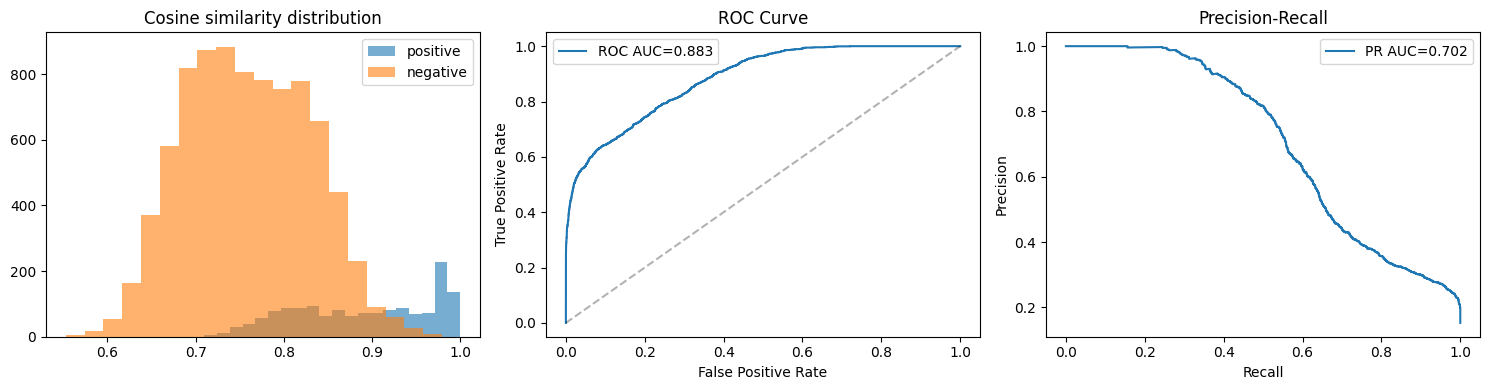

📈 Optimal Classification Threshold: 0.890
   F1 Score at threshold: 0.626
   Accuracy at threshold: 0.905
Relationship classifier not trained in this run; skipping confusion matrix plot.


In [29]:

# Similarity evaluation plots
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, roc_curve
import matplotlib.pyplot as plt

if not eval_examples:
    print('No eval examples; skipping similarity plots.')
else:
    eval_sents1 = [ex.texts[0] for ex in eval_examples]
    eval_sents2 = [ex.texts[1] for ex in eval_examples]
    labels = np.array([ex.label for ex in eval_examples])

    emb1 = model.encode(eval_sents1, convert_to_numpy=True, show_progress_bar=False)
    emb2 = model.encode(eval_sents2, convert_to_numpy=True, show_progress_bar=False)
    # cosine similarity
    norms1 = np.linalg.norm(emb1, axis=1)
    norms2 = np.linalg.norm(emb2, axis=1)
    cos_scores = np.sum(emb1 * emb2, axis=1) / (norms1 * norms2 + 1e-12)

    roc_auc = roc_auc_score(labels, cos_scores)
    pr_auc = average_precision_score(labels, cos_scores)
    fpr, tpr, _ = roc_curve(labels, cos_scores)
    precision, recall, _ = precision_recall_curve(labels, cos_scores)

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    axes[0].hist(cos_scores[labels==1], bins=20, alpha=0.6, label='positive')
    axes[0].hist(cos_scores[labels==0], bins=20, alpha=0.6, label='negative')
    axes[0].set_title('Cosine similarity distribution')
    axes[0].legend()

    axes[1].plot(fpr, tpr, label=f'ROC AUC={roc_auc:.3f}')
    axes[1].plot([0,1],[0,1],'k--', alpha=0.3)
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('ROC Curve')
    axes[1].legend()

    axes[2].plot(recall, precision, label=f'PR AUC={pr_auc:.3f}')
    axes[2].set_xlabel('Recall')
    axes[2].set_ylabel('Precision')
    axes[2].set_title('Precision-Recall')
    axes[2].legend()

    plt.tight_layout()
    plt.show()

    # Add threshold analysis
    thresholds = np.arange(0.3, 1.01, 0.01)
    best_f1 = 0
    best_threshold = 0

    for threshold in thresholds:
        preds = (cos_scores >= threshold).astype(int)
        f1 = f1_score(labels, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    print(f"📈 Optimal Classification Threshold: {best_threshold:.3f}")
    print(f"   F1 Score at threshold: {best_f1:.3f}")
    print(f"   Accuracy at threshold: {accuracy_score(labels, (cos_scores >= best_threshold).astype(int)):.3f}")

# Relationship classifier confusion matrix plot (if clf exists)
if 'clf' in globals() and 'label_names_ordered' in globals():
    cm = confusion_matrix(y_val, y_pred, labels=labels_order)
    fig, ax = plt.subplots(figsize=(4,4))
    im = ax.imshow(cm, cmap='Blues')
    ax.set_xticks(range(len(label_names_ordered)))
    ax.set_xticklabels(label_names_ordered, rotation=45, ha='right')
    ax.set_yticks(range(len(label_names_ordered)))
    ax.set_yticklabels(label_names_ordered)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title('Relationship Classifier Confusion')
    for (i,j), val in np.ndenumerate(cm):
        ax.text(j, i, int(val), ha='center', va='center', color='black')
    fig.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()
else:
    print('Relationship classifier not trained in this run; skipping confusion matrix plot.')
